In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss, adfuller, ccf, ccovf
from statsmodels.iolib.smpickle import load_pickle
import pmdarima as pm
from collections import deque

In [2]:
# from rpy2.robjects.packages import importr
# import rpy2.robjects.packages as rpackages
# from rpy2.robjects.vectors import StrVector, FloatVector
# %load_ext rpy2.ipython

In [6]:
horizon = pd.read_csv(".\\data\\horizon_multivariate_final.csv", encoding="utf-8")
horizon_diff = horizon.diff().dropna().to_numpy()
horizon.head()

,Average Effective Clock,CPU Overall Power Consumption,GPU Power,GPU Effective Clock,FPS
0,2295.4,99.895,305.353,1950.3,113
1,2598.2,104.135,341.418,1941.3,146
2,2741.5,107.012,345.209,1948.2,147
3,2660.6,105.918,342.610,1937.2,150
4,2598.3,103.853,345.456,1936.8,152


In [8]:
horizon_diff_train = horizon_diff[:-300]
horizon_diff_test = horizon_diff[-300:]

In [11]:
def find_VARMA_order_pq(pq_sum=5):
    pq_pair = [(p, pq_sum-p) for p in range(pq_sum+1)]
    fps_model_dict = {}
    fps_model_deque = deque([], maxlen=1)
    for (p, q) in pq_pair:
        model_result = VARMAX(horizon_diff_train, order=(p, q)).fit()
        fps_model_dict[f"result_{p}{q}"] = model_result
        if p==0:
            fps_model_deque.append(model_result)
            continue
        if fps_model_deque[0].aic > model_result.aic:
            fps_model_deque.append(model_result)
    return fps_model_dict, fps_model_deque

def find_VAR_order_p(start_p=1, max_p=5):
    p_list = [p for p in range(start_p, max_p+1)]
    fps_model_dict = {}
    fps_model_deque = deque([], maxlen=1)
    for p in p_list:
        model_result = VARMAX(horizon_diff_train, order=(p, 0)).fit()
        fps_model_dict[f"result_{p}0"] = model_result
        if p==start_p:
            fps_model_deque.append(model_result)
            continue
        if fps_model_deque[0].aic > model_result.aic:
            fps_model_deque.append(model_result)
    return fps_model_dict, fps_model_deque

In [7]:
# fps_var_model_dict, fps_var_model_deque = find_VAR_order_p()
# for (k, v) in fps_var_model_dict.items():
#     fps_var_model_dict[k].save(f".\\weights\\VAR\\VAR_{k}.pickle")
# fps_var_model_deque[0].summary()

In [ ]:
fps_model_dict, fps_model_deque = find_VARMA_order_pq()
for (k, v) in fps_model_dict.items():
    fps_model_dict[k].save(f".\\weights\\VARMA_{k}.pickle")

In [8]:
# VARMA_fps_result_23_diagonal = VARMAX(horizon_diff, order=(2, 3), error_cov_type="diagonal").fit()
# VARMA_fps_result_23_diagonal.save(".\\weights\\VARMA_fps_result_23_diagonal.pickle")
# VARMA_fps_result_23_diagonal = load_pickle(".\\weights\\VARMA_fps_result_23_diagonal.pickle")
# VARMA_fps_result_23_diagonal.summary()

In [9]:
VARMA_fps_result_23 = load_pickle(".\\weights\\VARMA_fps_result_23.pickle")
VARMA_fps_result_23.summary()

Dep. Variable:,"['y1', 'y2', 'y3', 'y4', 'y5']",No. Observations:,3192
Model:,"VARMA(2,3)",Log Likelihood,-64771.169
,+ intercept,AIC,129832.338
Date:,"Wed, 18 May 2022",BIC,130712.256
Time:,19:53:52,HQIC,130147.845
Sample:,0,,
,- 3192,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"16.29, 3.32, 9.12, 18.09, 2.58",Jarque-Bera (JB):,"24223.56, 18322.49, 496071.22, 1135218.19, 1666.54"
Prob(Q):,"0.00, 0.07, 0.00, 0.00, 0.11",Prob(JB):,"0.00, 0.00, 0.00, 0.00, 0.00"
Heteroskedasticity (H):,"0.84, 1.69, 1.07, 0.66, 1.18",Skew:,"-0.60, 1.11, -4.50, -3.71, 0.25"


In [10]:
# VARMA_fps_result_23.summary().tables[6].as_csv()
# with open(".\\weights\\VARMA_fps_result_23.csv", "w") as f_obj:
#     f_obj.write(VARMA_fps_result_23.summary().tables[6].as_csv())

In [11]:
VARMA_fps_result_23.impulse_responses(impulse=4, orthogonalized=False, steps=10)

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00],
       [-1.26744737e+00, -6.20478999e-02, -2.53926234e-03,
        -3.83775537e-01, -3.96439582e-01],
       [ 5.45167088e-01,  2.83068103e-02,  6.40830284e-02,
         3.48019852e-01, -2.05854357e-01],
       [ 7.54295986e-01,  2.36736089e-02,  1.64844059e-02,
         1.37189245e-01, -6.36190332e-02],
       [-3.62965476e-01, -9.60746903e-03, -3.54782865e-02,
        -1.62280029e-01,  6.15525169e-02],
       [-8.83332015e-02, -4.08766390e-03,  1.33900654e-02,
         3.66411950e-02, -7.05128390e-03],
       [ 1.15554307e-01,  3.23418813e-03,  3.13743691e-03,
         1.63343085e-02, -9.32538466e-03],
       [-8.71370293e-03,  3.24769878e-04, -4.35175903e-03,
        -7.36377726e-03,  4.11139118e-03],
       [-2.68543241e-02, -9.24024959e-04,  9.90517722e-04,
        -2.23145804e-03,  3.95743190e-04],
       [ 9.58912969e-03,  1.69840853e-04,  4.27544686e-04,
        -1.42391791e-04

In [12]:
VARMA_fps_result_23.coefficient_matrices_var.shape

(2, 5, 5)

In [13]:
VARMA_fps_result_23.coefficient_matrices_vma.shape

(3, 5, 5)

In [14]:
VARMA_fps_result_23.test_serial_correlation(method="ljungbox", lags=12)[4, 1, :]

array([1.08018837e-01, 1.77683056e-01, 3.20007768e-01, 6.82550660e-04,
       2.01857934e-04, 4.39231756e-04, 1.10832723e-04, 1.38165088e-04,
       5.57331700e-05, 3.92664547e-05, 3.36963042e-05, 6.64244928e-05])

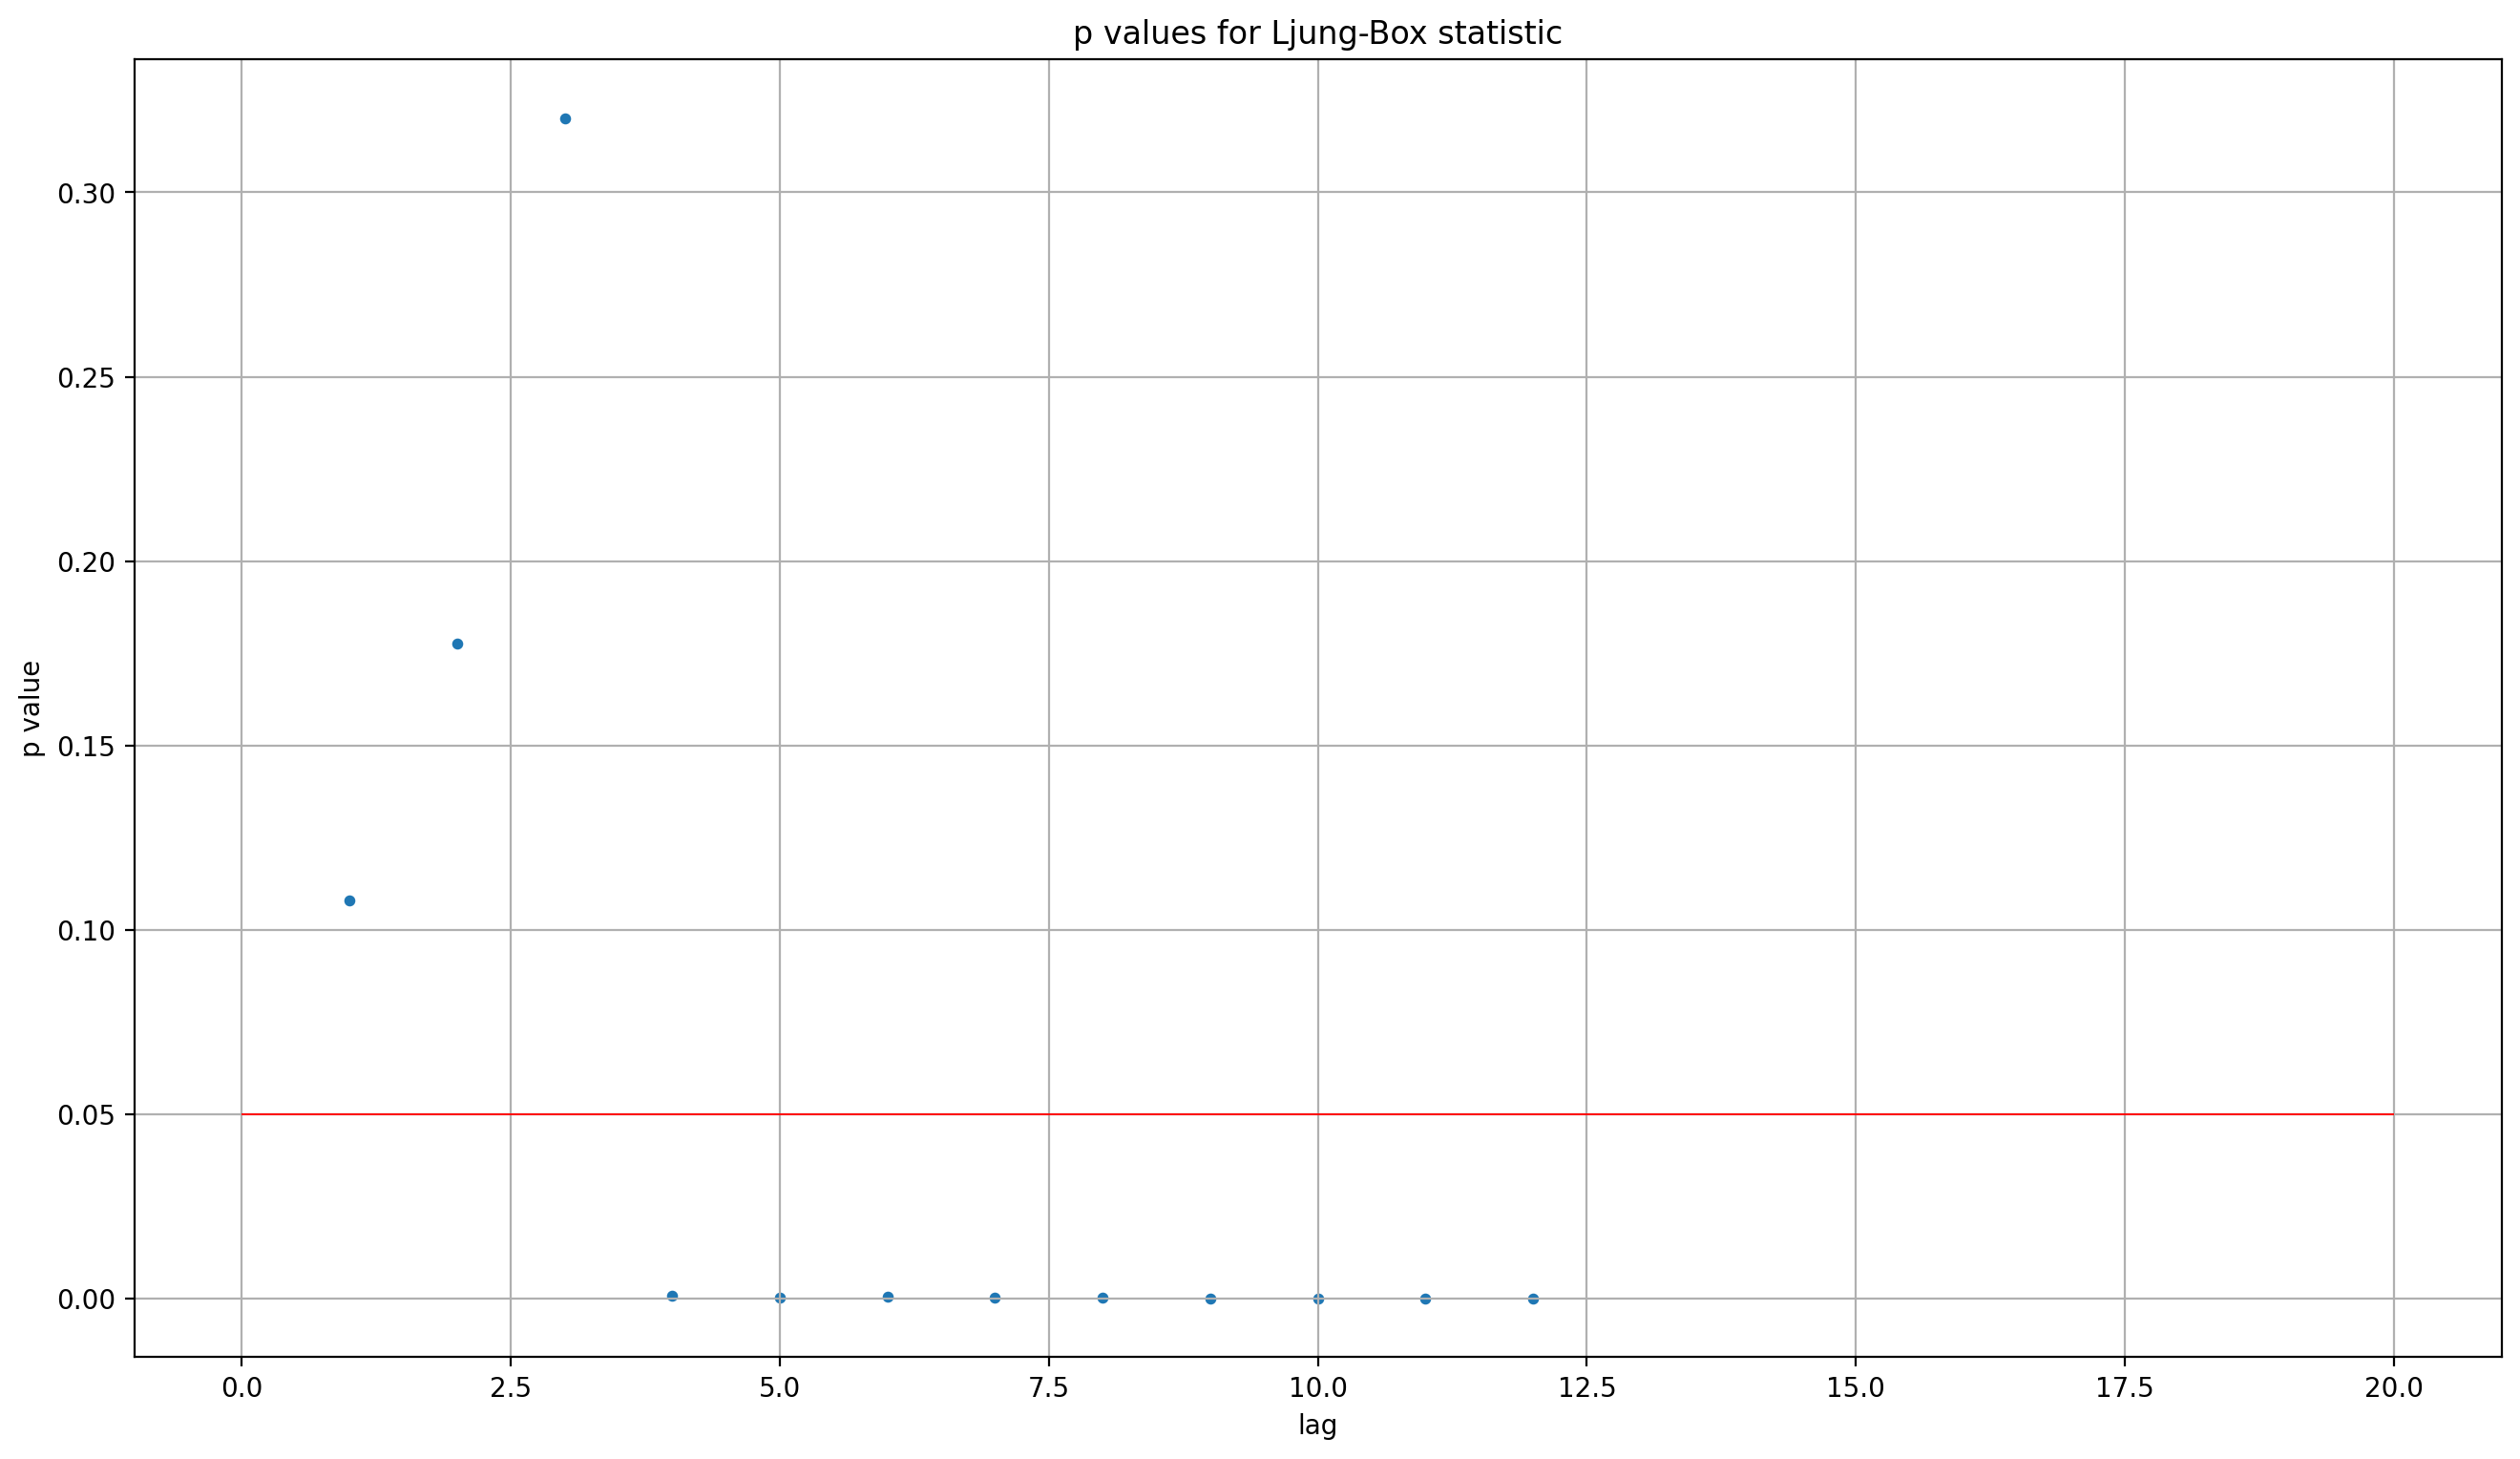

In [15]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(list(range(1,13)), VARMA_fps_result_23.test_serial_correlation(method="ljungbox", lags=12)[4, 1, :], s=10)
plt.hlines(y=[0.05], xmin=0, xmax=20, colors="r", linewidths=0.7)
# plt.axis([0, 20, 0, 1])
plt.title("p values for Ljung-Box statistic")
plt.xlabel("lag")
plt.ylabel("p value")
plt.grid()
plt.show()

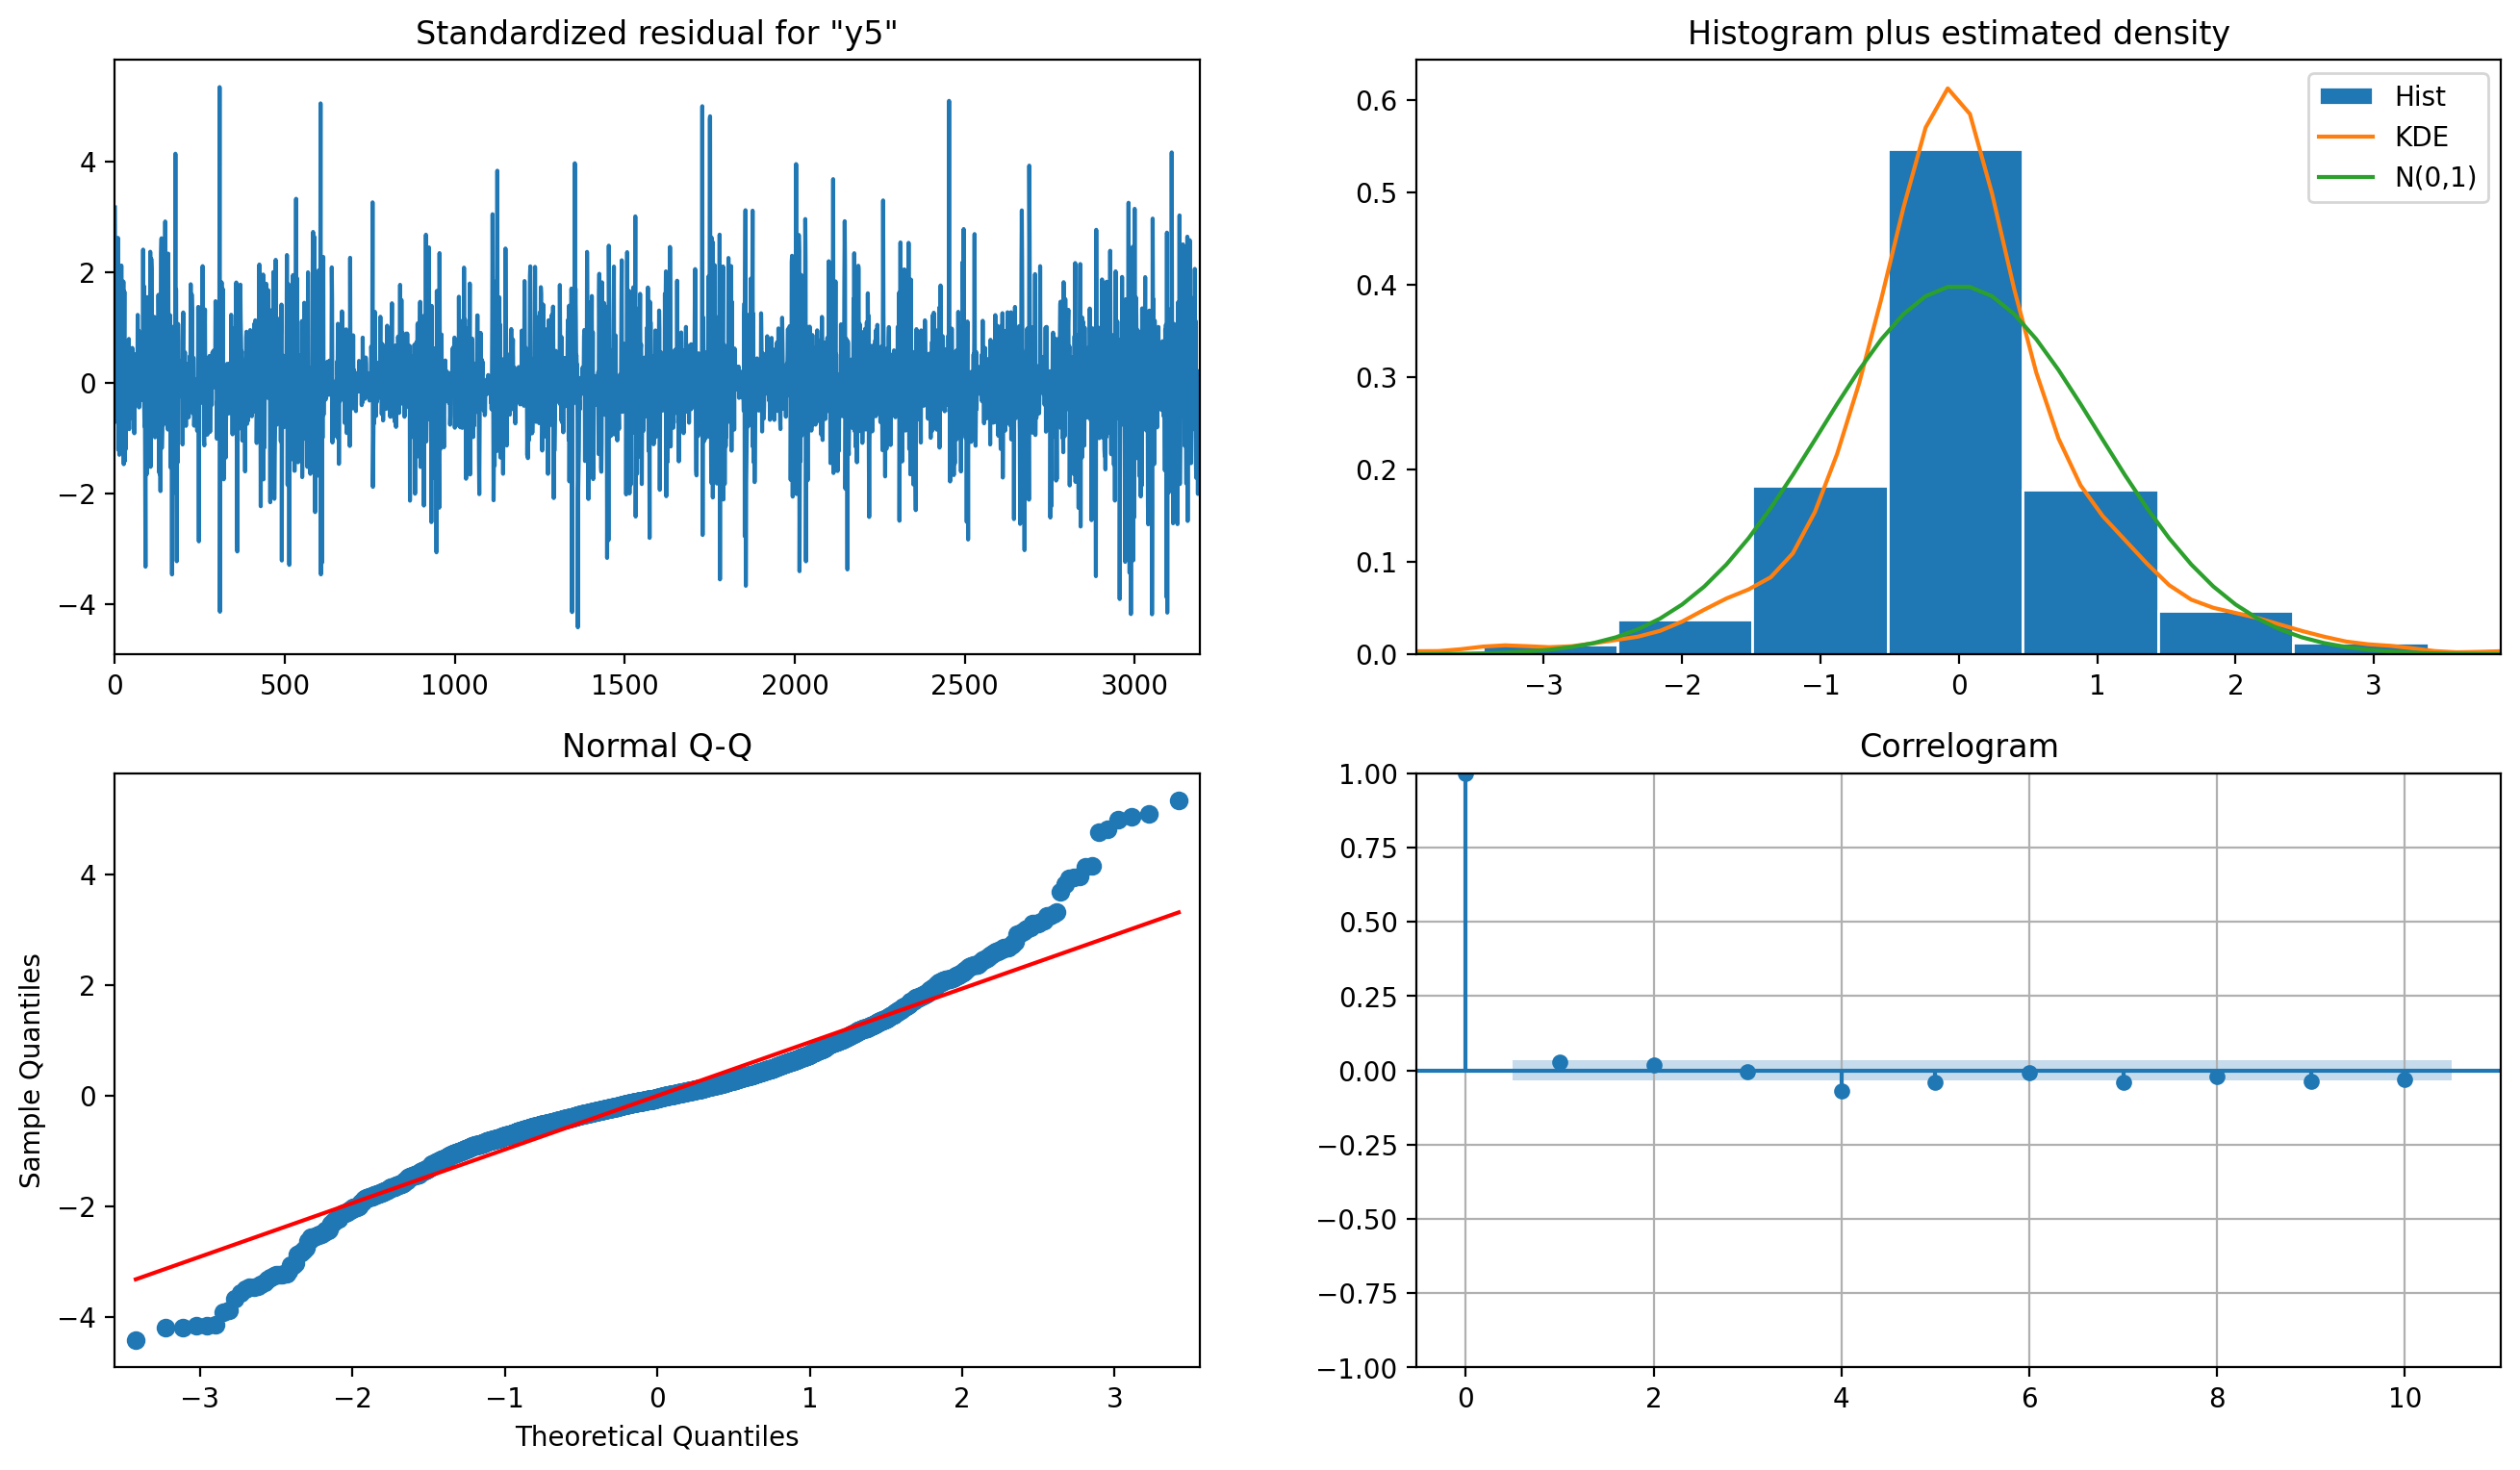

In [16]:
VARMA_fps_result_23.plot_diagnostics(variable=4, fig=plt.figure(figsize=(16,9), dpi=200))
plt.grid()
plt.show()